In [1]:
import time
import neo4j
import pandas as pd
from tqdm import tqdm
import geopy.distance
import matplotlib.pyplot as plt
import pickle

### Connect to database

In [2]:
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "krakow123"
NEO4J_DATABASE = "neo4j"

driver = neo4j.GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD), database=NEO4J_DATABASE)

### Get result helper function

In [3]:
def print_result(results):
    result = [dict(i) for i in results]
    print(result)
    
    result_all = results.consume()
    print(f"result_consumed_after: {result_all.result_consumed_after} ms")
    print(f"result_available_after: {result_all.result_available_after} ms\n")

### Check database numbers

In [11]:
nodes_and_rels_nb_query = """
    CALL apoc.meta.stats() 
    YIELD nodeCount, relCount
    RETURN *
"""

In [16]:
with driver.session() as session:
    results = session.run(nodes_and_rels_nb_query)
    print_result(results)

[{'nodeCount': 1088378, 'relCount': 2274488}]
result_consumed_after: 150 ms
result_available_after: 34 ms



### Plotting function

In [4]:
def plot_query_times(query_times, save=False, filepath=None):
    query_nb = [i for i in range(1, len(query_times) + 1)]
    plt.plot(query_nb, query_times, marker=".", color="teal")
    plt.xlabel("Query number")
    plt.ylabel("Query execution time [ms]")
    
    if save:
        plt.show()
        plt.savefig(filepath, bbox_inches="tight", dpi=200)
        plt.close()
        
    else:
        plt.show()

### Nodes selection

In [16]:
# nodes = pd.read_csv("./data/krakow/nodes_neo4j.csv")

In [17]:
# # two random osmid
# distance_small = 0
# osmid_1_small = 0
# osmid_2_small = 0

# while distance_small < 25:
#     start_and_finish = nodes.sample(2)

#     osmid_1_small = int(start_and_finish.iloc[0]["osmid"])
#     osmid_2_small = int(start_and_finish.iloc[1]["osmid"])

#     coords_1 = start_and_finish.iloc[0]["y"], start_and_finish.iloc[0]["x"]
#     coords_2 = start_and_finish.iloc[1]["y"], start_and_finish.iloc[1]["x"]
    
#     distance_small = geopy.distance.distance(coords_1, coords_2).km

# print(f"osmid_1_small: {osmid_1_small}, osmid_2_small: {osmid_2_small}, distance: {distance_small} km")

osmid_1_small: 9589826850, osmid_2_small: 9723732263, distance: 28.247114621190956 km


In [5]:
osmid_1_short = 262220894
osmid_2_short = 6949642867

osmid_1_long = 4538716538
osmid_2_long = 432648629

### Paths queries and parsing query time

In [6]:
def parse_query_time(results):
    _ = [dict(i) for i in results]
    result_all = results.consume()
    return int(result_all.result_consumed_after)

## Dijkstra

In [7]:
def dijkstra_query_short_undirected(tx, osmid_1_short, osmid_2_short):
    dijkstra_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_short}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_short}}})
        CALL apoc.algo.dijkstra(source, target, "ROAD_SEGMENT", "length")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(dijkstra_query_string)
    query_time = parse_query_time(results)
    return query_time
    
def dijkstra_query_short_directed(tx, osmid_1_short, osmid_2_short):
    dijkstra_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_short}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_short}}})
        CALL apoc.algo.dijkstra(source, target, "ROAD_SEGMENT>", "length")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(dijkstra_query_string)
    query_time = parse_query_time(results)
    return query_time

def dijkstra_query_long_undirected(tx, osmid_1_long, osmid_2_long):
    dijkstra_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_long}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_long}}})
        CALL apoc.algo.dijkstra(source, target, "ROAD_SEGMENT", "length")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(dijkstra_query_string)
    query_time = parse_query_time(results)
    return query_time

def dijkstra_query_long_directed(tx, osmid_1_long, osmid_2_long):
    dijkstra_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_long}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_long}}})
        CALL apoc.algo.dijkstra(source, target, "ROAD_SEGMENT>", "length")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(dijkstra_query_string)
    query_time = parse_query_time(results)
    return query_time

## Astar

In [8]:
def astar_query_short_undirected(tx, osmid_1_short, osmid_2_short):
    astar_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_short}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_short}}})
        CALL apoc.algo.aStar(source, target, "ROAD_SEGMENT", "length", "latitude", "longitude")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(astar_query_string)
    query_time = parse_query_time(results)
    return query_time

def astar_query_short_directed(tx, osmid_1_short, osmid_2_short):
    astar_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_short}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_short}}})
        CALL apoc.algo.aStar(source, target, "ROAD_SEGMENT>", "length", "latitude", "longitude")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(astar_query_string)
    query_time = parse_query_time(results)
    return query_time

def astar_query_long_undirected(tx, osmid_1_long, osmid_2_long):
    astar_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_long}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_long}}})
        CALL apoc.algo.aStar(source, target, "ROAD_SEGMENT", "length", "latitude", "longitude")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(astar_query_string)
    query_time = parse_query_time(results)
    return query_time

def astar_query_long_directed(tx, osmid_1_long, osmid_2_long):
    astar_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1_long}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2_long}}})
        CALL apoc.algo.aStar(source, target, "ROAD_SEGMENT>", "length", "latitude", "longitude")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(astar_query_string)
    query_time = parse_query_time(results)
    return query_time

### How many queries

In [8]:
query_number = 15

### dijkstra short distance, directed

Query:   0%|          | 0/15 [00:00<?, ?it/s]

Query: 100%|██████████| 15/15 [05:12<00:00, 20.84s/it]


queries times: [18939, 18073, 18383, 16774, 19386, 23156, 15174, 23689, 15503, 21458, 27974, 22629, 23968, 25634, 15324]


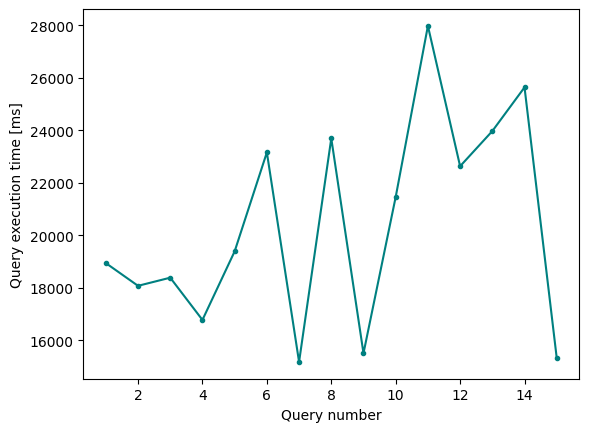

In [9]:
dijkstra_short_directed_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(dijkstra_query_short_directed, osmid_1_short, osmid_2_short)
        dijkstra_short_directed_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {dijkstra_short_directed_query_times_neo4j}")

plot_query_times(dijkstra_short_directed_query_times_neo4j)

pickle.dump(dijkstra_short_directed_query_times_neo4j, open("./results/krakow_120/dijkstra_short_directed_query_times_neo4j.bin", "wb"))


### dijkstra short distance, undirected

Query: 100%|██████████| 15/15 [02:08<00:00,  8.57s/it]


queries times: [10303, 7708, 6906, 8286, 10059, 6211, 7335, 9918, 6584, 10282, 6415, 9987, 6623, 9971, 7335]


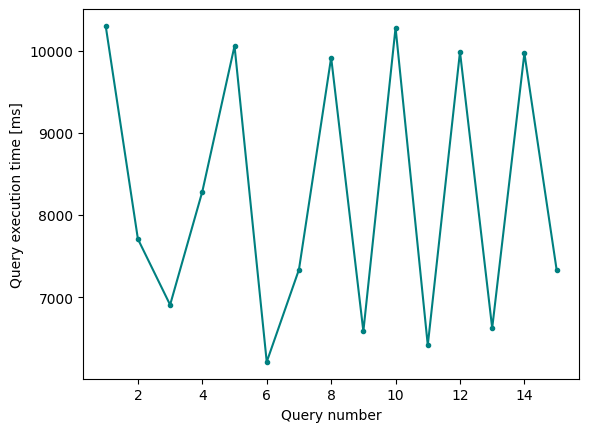

In [14]:
dijkstra_short_undirected_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(dijkstra_query_short_undirected, osmid_1_short, osmid_2_short)
        dijkstra_short_undirected_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {dijkstra_short_undirected_query_times_neo4j}")

plot_query_times(dijkstra_short_undirected_query_times_neo4j)

pickle.dump(dijkstra_short_undirected_query_times_neo4j, open("./results/krakow_120/dijkstra_short_undirected_query_times_neo4j.bin", "wb"))


### Astar short distance, directed

Query: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


queries times: [1534, 266, 231, 185, 170, 166, 177, 149, 166, 165, 162, 145, 146, 176, 159]


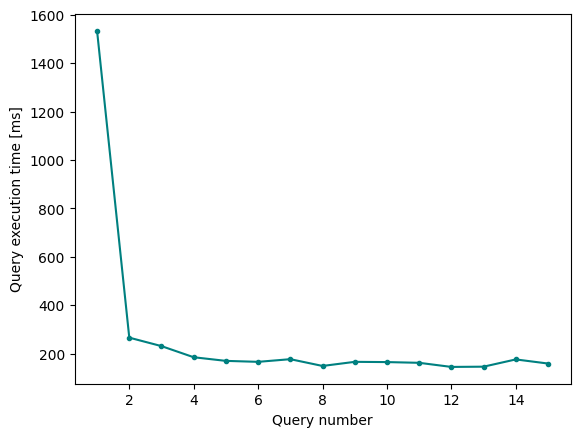

In [24]:
astar_short_directed_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(astar_query_short_directed, osmid_1_short, osmid_2_short)
        astar_short_directed_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {astar_short_directed_query_times_neo4j}")

plot_query_times(astar_short_directed_query_times_neo4j)

pickle.dump(astar_short_directed_query_times_neo4j, open("./results/krakow_120/astar_short_directed_query_times_neo4j.bin", "wb"))


### Astar short distance, undirected

Query: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

queries times: [427, 231, 133, 115, 99, 102, 83, 80, 87, 84, 83, 80, 97, 83, 100]


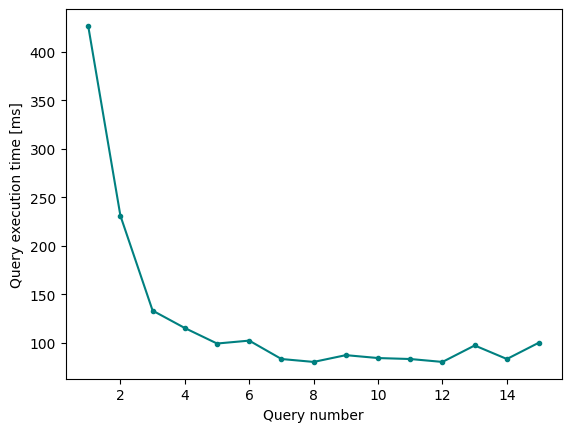

In [26]:
astar_short_undirected_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(astar_query_short_undirected, osmid_1_short, osmid_2_short)
        astar_short_undirected_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {astar_short_undirected_query_times_neo4j}")

plot_query_times(astar_short_undirected_query_times_neo4j)

pickle.dump(astar_short_undirected_query_times_neo4j, open("./results/krakow_120/astar_short_undirected_query_times_neo4j.bin", "wb"))


In [8]:
query_number = 5

### Dijkstra long distance, directed

Query:   0%|          | 0/5 [00:00<?, ?it/s]

Query: 100%|██████████| 5/5 [40:36<00:00, 487.37s/it]


queries times: [389156, 446274, 503803, 533761, 558318]


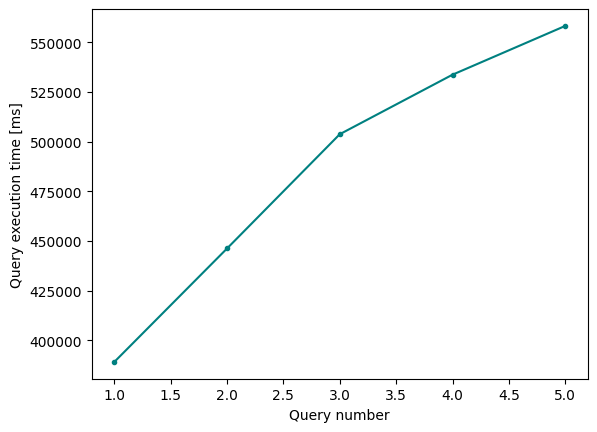

In [9]:
dijkstra_long_directed_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(dijkstra_query_long_directed, osmid_1_long, osmid_2_long)
        dijkstra_long_directed_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {dijkstra_long_directed_query_times_neo4j}")

plot_query_times(dijkstra_long_directed_query_times_neo4j)

pickle.dump(dijkstra_long_directed_query_times_neo4j, open("./results/krakow_120/dijkstra_long_directed_query_times_neo4j.bin", "wb"))


### Dijkstra long distance, undirected

Query: 100%|██████████| 5/5 [45:56<00:00, 551.36s/it]


queries times: [477174, 541462, 565458, 592610, 564431]


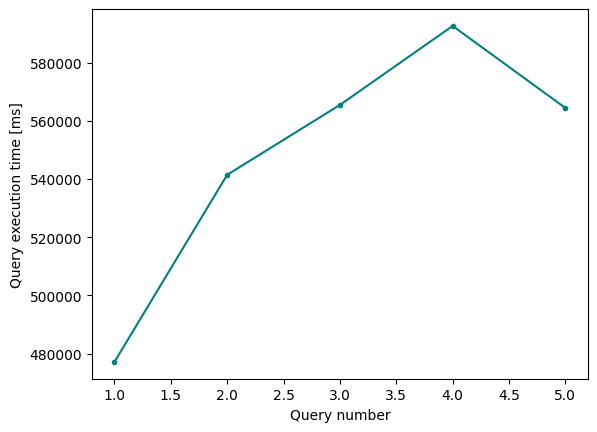

In [11]:
dijkstra_long_undirected_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(dijkstra_query_long_undirected, osmid_1_long, osmid_2_long)
        dijkstra_long_undirected_query_times_neo4j.append(query_time)
    time.sleep(2)
    
print(f"queries times: {dijkstra_long_undirected_query_times_neo4j}")

plot_query_times(dijkstra_long_undirected_query_times_neo4j)

pickle.dump(dijkstra_long_undirected_query_times_neo4j, open("./results/krakow_120/dijkstra_long_undirected_query_times_neo4j.bin", "wb"))


### Astar long distance, directed

Query: 100%|██████████| 5/5 [00:42<00:00,  8.54s/it]

queries times: [7922, 7642, 7176, 7070, 7016]


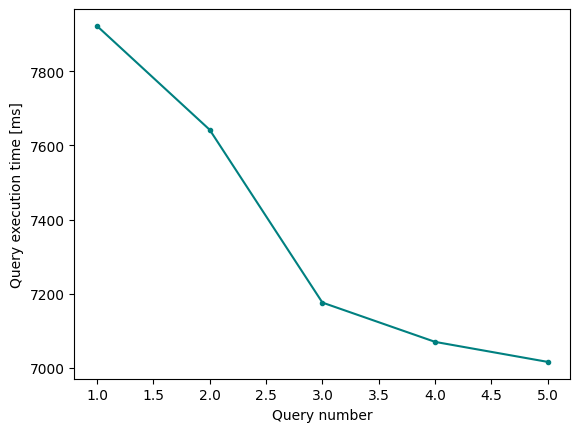

In [33]:
astar_long_directed_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(astar_query_long_directed, osmid_1_long, osmid_2_long)
        astar_long_directed_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {astar_long_directed_query_times_neo4j}")

plot_query_times(astar_long_directed_query_times_neo4j)

pickle.dump(astar_long_directed_query_times_neo4j, open("./results/krakow_120/astar_long_directed_query_times_neo4j.bin", "wb"))


### Astar long distance, undirected

Query: 100%|██████████| 5/5 [00:55<00:00, 11.00s/it]


queries times: [10636, 9597, 9770, 9686, 9690]


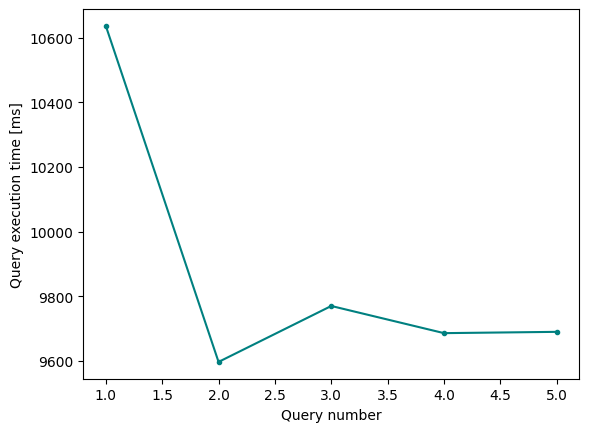

In [36]:
astar_long_undirected_query_times_neo4j = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(astar_query_long_undirected, osmid_1_long, osmid_2_long)
        astar_long_undirected_query_times_neo4j.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {astar_long_undirected_query_times_neo4j}")

plot_query_times(astar_long_undirected_query_times_neo4j)

pickle.dump(astar_long_undirected_query_times_neo4j, open("./results/krakow_120/astar_long_undirected_query_times_neo4j.bin", "wb"))

# save results

In [ ]:
pickle.dump(dijkstra_short_directed_query_times_neo4j, open("./results/krakow_120/dijkstra_short_directed_query_times_neo4j.bin", "wb"))
pickle.dump(dijkstra_short_undirected_query_times_neo4j, open("./results/krakow_120/dijkstra_short_undirected_query_times_neo4j.bin", "wb"))
pickle.dump(astar_short_directed_query_times_neo4j, open("./results/krakow_120/astar_short_directed_query_times_neo4j.bin", "wb"))
pickle.dump(astar_short_undirected_query_times_neo4j, open("./results/krakow_120/astar_short_undirected_query_times_neo4j.bin", "wb"))

pickle.dump(dijkstra_long_directed_query_times_neo4j, open("./results/krakow_120/dijkstra_long_directed_query_times_neo4j.bin", "wb"))
pickle.dump(dijkstra_long_undirected_query_times_neo4j, open("./results/krakow_120/dijkstra_long_undirected_query_times_neo4j.bin", "wb"))
pickle.dump(astar_long_directed_query_times_neo4j, open("./results/krakow_120/astar_long_directed_query_times_neo4j.bin", "wb"))
pickle.dump(astar_long_undirected_query_times_neo4j, open("./results/krakow_120/astar_long_undirected_query_times_neo4j.bin", "wb"))



# dijkstra_short_directed_query_times_neo4j
# dijkstra_short_undirected_query_times_neo4j
# astar_short_directed_query_times_neo4j
# astar_short_undirected_query_times_neo4j

# dijkstra_long_directed_query_times_neo4j
# dijkstra_long_undirected_query_times_neo4j
# astar_long_directed_query_times_neo4j
# astar_long_undirected_query_times_neo4j